## Project description
You work for the online store Ice, which sells video games all over the world. User and expert reviews, genres, platforms (e.g. Xbox or PlayStation), and historical data on game sales are available from open sources. You need to identify patterns that determine whether a game succeeds or not. This will allow you to spot potential big winners and plan advertising campaigns.
In front of you is data going back to 2016. Let’s imagine that it’s December 2016 and you’re planning a campaign for 2017.
(The important thing is to get experience working with data. It doesn't really matter whether you're forecasting 2017 sales based on data from 2016 or 2017 sales based on data from 2016.)
The dataset contains the abbreviation ESRB. The Entertainment Software Rating Board evaluates a game's content and assigns an age rating such as Teen or Mature.

In [1]:
import matplotlib as mpl 
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
from dateutil.parser import parse
import numpy as np


In [30]:
games_df = pd.read_csv('/Users/edeng/Practicum projects/games.csv')

In [3]:
games_df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


## Step 2. Prepare the data

Replacing the column names (make them lowercase).

In [5]:
games_df['Name'] = games_df['Name'].str.lower()
games_df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,wii sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,super mario bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,mario kart wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,wii sports resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,pokemon red/pokemon blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Checking for duplicates

In [6]:
games_df.duplicated().sum()

0

Checking column content before datatype change

In [7]:
print(games_df['Year_of_Release'].unique())
games_df['User_Score'].unique()


[2006. 1985. 2008. 2009. 1996. 1989. 1984. 2005. 1999. 2007. 2010. 2013.
 2004. 1990. 1988. 2002. 2001. 2011. 1998. 2015. 2012. 2014. 1992. 1997.
 1993. 1994. 1982. 2016. 2003. 1986. 2000.   nan 1995. 1991. 1981. 1987.
 1980. 1983.]


array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Converting the data to the required types: Year_of_Release to datetime as float is not needed and missing values will be filled with year where we can find games that their year is already known in our data, else we will fill missing value based on the year we can find in their name, lastly with a placeholder 0 as there is no way to recover the year of release without manually curating it. User_score to float as values contains float numbers. TBD values will be converted no Nan.

In [8]:
#removing 2 rows where Name and Genre is Nan
games_df=games_df[games_df['Name'].notna()]
#Filling in missing Year_of_Release values when we already have the year of release for the same
#game in our data.
f = lambda x: x.fillna(x.mode().iat[0]) if x.notna().any() else x
games_df['Year_of_Release']=games_df.groupby('Name')['Year_of_Release']\
.apply(f)
games_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16713 non-null  object 
 2   Year_of_Release  16567 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16713 non-null  float64
 5   EU_sales         16713 non-null  float64
 6   JP_sales         16713 non-null  float64
 7   Other_sales      16713 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


In [9]:
#removing parentheses as parse cannot access the value within it.
games_df['Name']=games_df['Name'].replace(to_replace=['\(','\)'] , value="", regex=True)

#function that return the year if it's on the name, and 0 if there is not.
def parsel(x, y):
    if pd.isna(y)==True:
        if '200' in x:
            try:
                parse1=parse(x, fuzzy=True, yearfirst=False).year
                return parse1
            except:
                pass
        elif '201' in x:
            try:
                parse1=parse(x, fuzzy=True, yearfirst=False).year
                return parse1
            except:
                pass
        else:
            return 0
    else:
        return y

#filling Year_of_Release with the function
games_df['Year_of_Release']=[parsel(x, y) for x, y in zip(games_df['Name'], games_df['Year_of_Release'])]
#changing Year_of_Release to int
games_df['Year_of_Release']=games_df['Year_of_Release'].astype(int)
games_df.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16713.000000,16713.000000,16713.000000,16713.000000,16713.000000,8137.000000
mean,1989.802369,0.263302,0.145045,0.077625,0.047343,68.967679
std,182.322139,0.813565,0.503359,0.308871,0.186742,13.938165
min,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [10]:
games_df.describe(include='object')

,Name,Platform,Genre,User_Score,Rating
count,16713,16713,16713,10014,9949
unique,11559,31,12,96,8
top,need for speed: most wanted,PS2,Action,tbd,E
freq,12,2161,3369,2424,3990


In [11]:
games_df.isna().sum()

Name                  0
Platform              0
Year_of_Release       0
Genre                 0
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8576
User_Score         6699
Rating             6764
dtype: int64

Checking if user score TBD need fixing.

In [12]:
print(games_df[games_df.User_Score=='tbd']['Year_of_Release'].value_counts())
#we can see the user score is not updated, therefor replacing tbd to nan
games_df['User_Score']=games_df['User_Score'].replace('tbd', np.nan).astype(float, errors='ignore')

2009    405
2010    333
2008    330
2011    218
2007    193
2002    193
2006    127
2005    122
2004    107
2003     97
2001     84
2000     43
2015     38
2016     34
0        29
2012     26
2014     21
2013     15
1999      8
1997      1
Name: Year_of_Release, dtype: int64


Calculate the total sales (the sum of sales in all regions) and storing it in 'total sale' column

In [13]:
games_df['total_sale'] = games_df['NA_sales']+ games_df['EU_sales'] + games_df['JP_sales'] + games_df['Other_sales']

## Step 3. Analyze the data

Checking how many games were released in different years.

In [14]:
clean_df=games_df.groupby('Year_of_Release')['Name'].count().reset_index()
clean_df=clean_df[clean_df['Year_of_Release']!=0]
print(clean_df.Name.mean())
clean_df

447.94594594594594


,Year_of_Release,Name
1,1980,9
2,1981,46
3,1982,36
4,1983,17
5,1984,14
6,1985,14
7,1986,21
8,1987,16
9,1988,15
10,1989,17


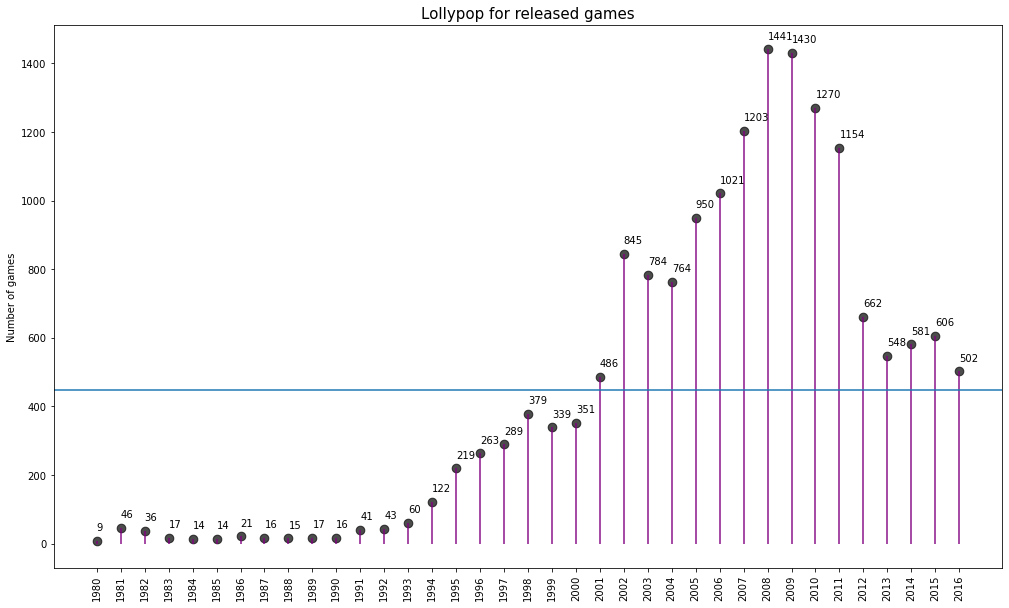

In [15]:
fig,ax=plt.subplots(figsize=(17,10))
ax.vlines(x=clean_df.Year_of_Release, ymin=0, ymax=clean_df.Name, color='purple', alpha=0.7, linewidth=2)
ax.scatter(x=clean_df.Year_of_Release, y=clean_df.Name, s=75, color='black', alpha=0.7)

ax.set_title('Lollypop for released games', fontdict={'size':15})
ax.set_ylabel('Number of games')
ax.set_xticks(clean_df.Year_of_Release)
ax.set_xticklabels(clean_df.Year_of_Release, rotation=90)
ax.axhline(y=clean_df.Name.mean())

for row in clean_df.itertuples():
    ax.text(row.Year_of_Release, row.Name+30, s=round(row.Name))

We can see that on avergae the most of games were released form 2001

Looking at how sales varied from platform to platform. Choosing the platforms with the greatest total sales and building a distribution based on data for each year. 

In [16]:
top_platforms=games_df.groupby('Platform')['total_sale'].sum().reset_index()\
.sort_values('total_sale', ascending=False).head()['Platform']
top_platforms

16     PS2
28    X360
17     PS3
26     Wii
4       DS
Name: Platform, dtype: object

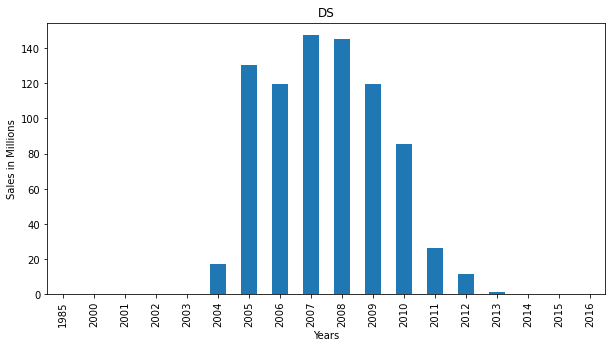

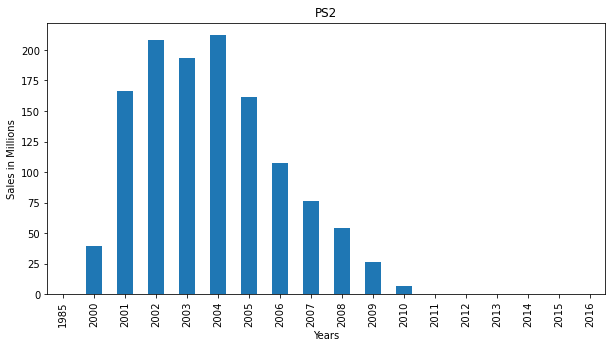

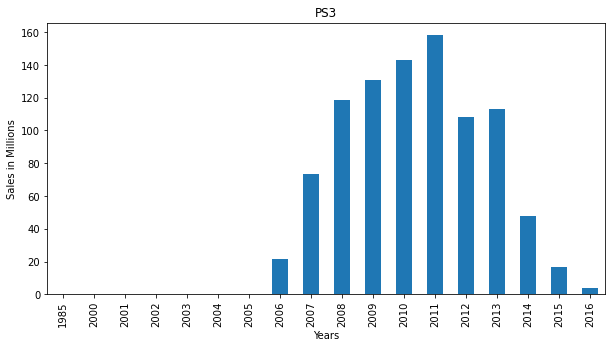

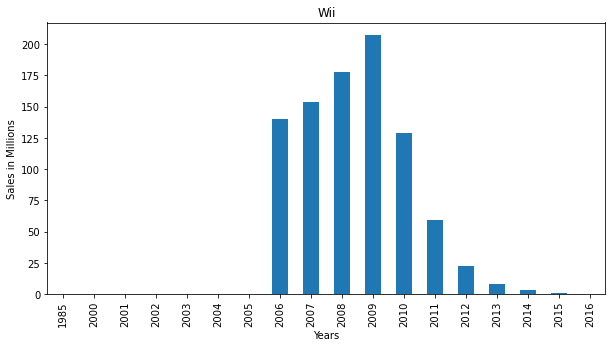

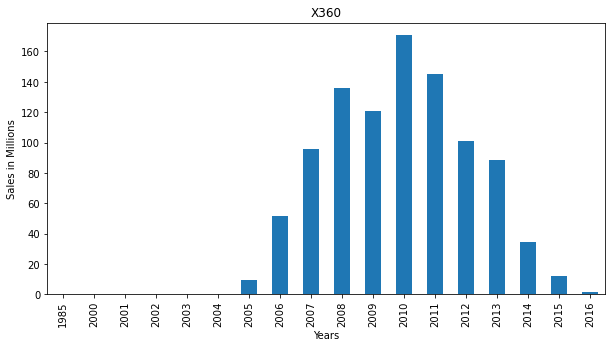

In [17]:
#filtering the top platforms from the games_df
top_platforms_df=games_df.query('Platform in @top_platforms')
#creating a pivot table of the top platforms 
top_platforms_sales=top_platforms_df.pivot_table(values='total_sale', index='Year_of_Release', columns='Platform', aggfunc='sum')
#droping year 0 from the table as it won't effect the data.
top_platforms_sales.drop(top_platforms_sales[top_platforms_sales.index==0].index, inplace=True)
#printing the graphs
for i in top_platforms_sales:
    plt.figure()
    top_platforms_sales[i].plot.bar(figsize=(10, 5))
    plt.title(i)
    plt.ylabel('Sales in Millions')
    plt.xlabel('Years')
    plt.show()

We can see that for the 5 most popular platforms, it took about 10 to 11 years for the sales to fade after inception. Per the graphs we can see that the sales peak 4-5 years afetr inception, and sales start to decrease after that. 

Next I going to check which platforms are leading in sales and which ones are growing or shrinking. Selecting several potentially profitable platforms, from 2001 to 2016

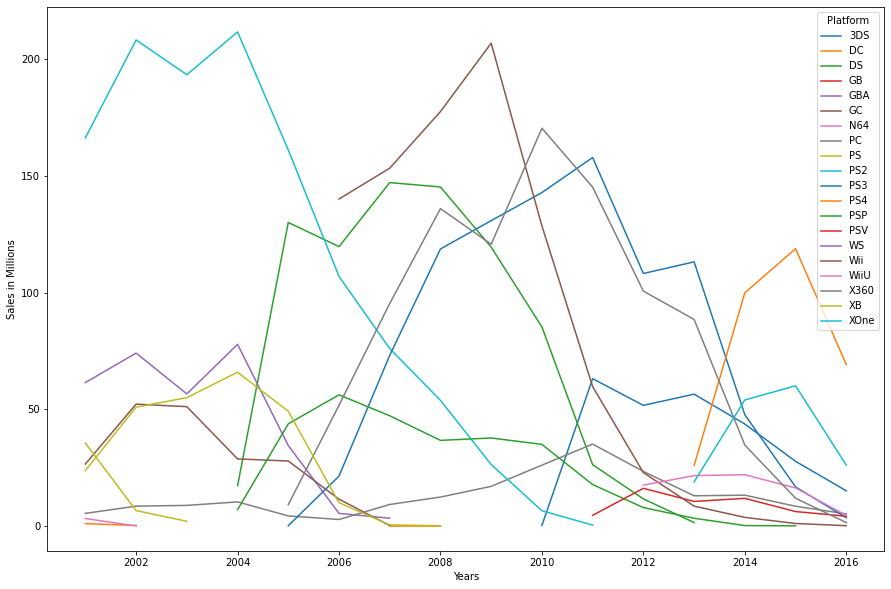

In [18]:
#new df for years over 2000
platform=games_df[games_df.Year_of_Release >= 2001]
#creating another pivot
platform1=platform.pivot_table(values='total_sale', index='Year_of_Release', columns='Platform', aggfunc='sum')
#printing the graph
platform1.plot(figsize=(15, 10))
plt.ylabel('Sales in Millions')
plt.xlabel('Years')
plt.show()

We can see that there are more then handfull of platforms that their sales are shrinking and their sales are below 50 millions. PS4 has the highest total sales above 50 million, but still lower by 50% from last year(2015), but as the data for 2016 is incomplete we can't deduct that their sales are shrinking. Same goes for XOne which was released in 2013 and had a strong 2015.

Building a box plot for the global sales of all games, broken down by platform. Checking if the differences in sales significant, and what are the average sales on various platforms. 

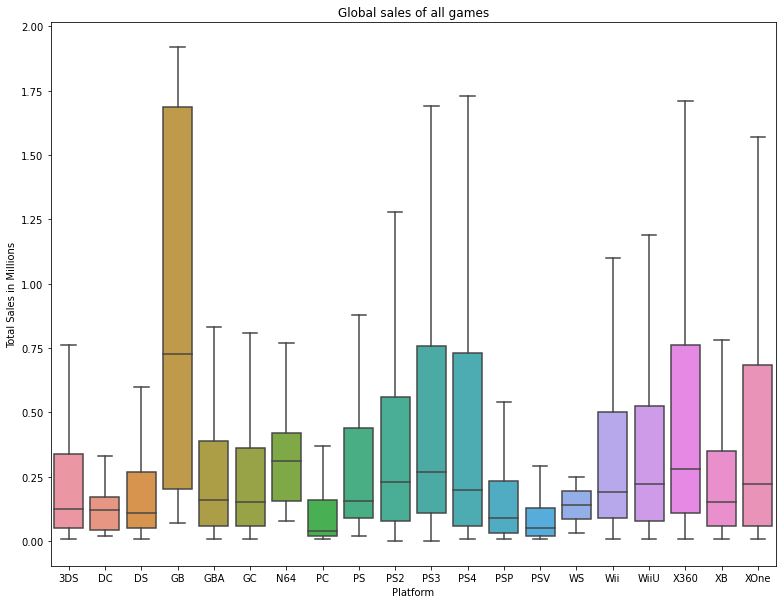

In [19]:
#creating a pivot df breakdown by platform and games
platform_breakdown=platform.pivot_table(index='Name', columns='Platform', values='total_sale', aggfunc='sum')
#setting the plot figsize
plt.figure(figsize=(13,10))
#printing the boxplots for each platform
sns.boxplot(data=platform_breakdown, showfliers=False).set(title='Global sales of all games', ylabel='Total Sales in Millions')

plt.show()

We can see from the boxplots that the average sales for the top platforms do no differ greatly. We see that GB has big verience and higher mean due to large outliers.

Taking a look at how user and professional reviews affect sales for one popular platform. Building a scatter plot and calculating the correlation between reviews and sales, and comparing the sales of the same games on other platforms.

There isn't a strong correlation between critic score and total sales for: PS2
The correlation is: 0.39543454945455137


<Figure size 360x360 with 0 Axes>

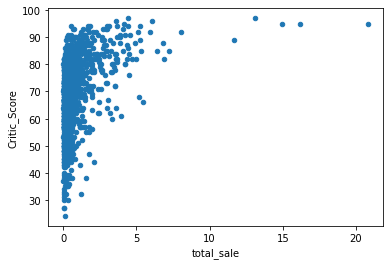

There isn't a strong correlation between critic score and total sales for: X360
The correlation is: 0.3937358653072582


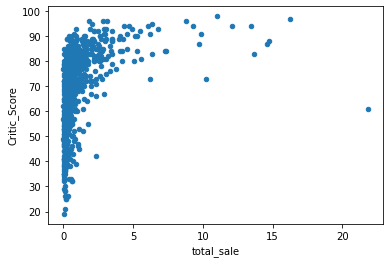

There isn't a strong correlation between critic score and total sales for: PS3
The correlation is: 0.4324315685642066


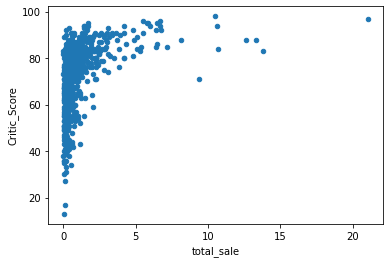

There isn't a strong correlation between critic score and total sales for: Wii
The correlation is: 0.17755988806089978


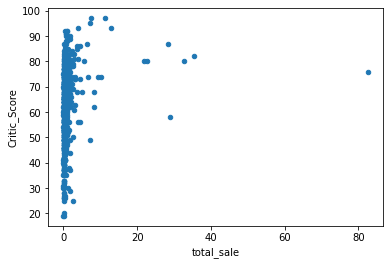

There isn't a strong correlation between critic score and total sales for: DS
The correlation is: 0.23637945738859611


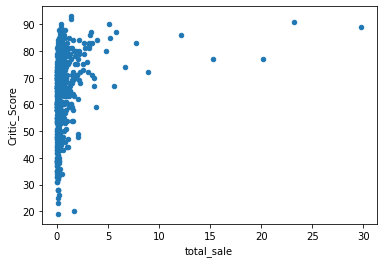

In [20]:
plt.figure(figsize=(5,5))
def score_effect(platform):
    for i in platform:
        platform_df=games_df[(games_df.Platform==i) & (games_df.Critic_Score.notna())][['Critic_Score', 'total_sale']]
        platform_df.plot.scatter(x='total_sale', y='Critic_Score')
        correlation=platform_df.corr()
        if correlation.iloc[0][1] > 0.7:
            print('There is a strong correlation between critic score and total sales for:', i)
        else:
            print("There isn't a strong correlation between critic score and total sales for:", i)
            print("The correlation is:", correlation.iloc[0][1])
        plt.show()
    
score_effect(top_platforms)


We can see that proffesional reviews have no great effect on total sales. There is a visible effect where higher scored games above 75 have in average more total sales then lower scored games.

A nice visualization on total sale of games that were released on multiple platforms.

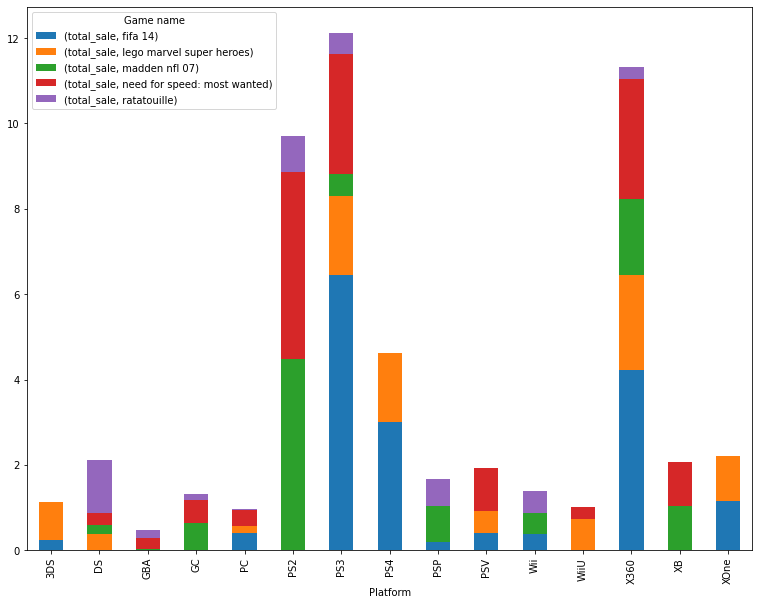

In [21]:
#creating a pivot table to show games and their platforms
same_games=games_df.pivot_table(index=['Platform', 'Name'], values='total_sale', aggfunc='sum')
#filtering the pivot to show a df with games that were released in more then 8 platforms
same_games=same_games.groupby('Name').filter(lambda x: len(x) > 8)
same_games.unstack().plot(kind='bar', stacked=True, figsize=(13,10))
plt.legend(title = 'Game name')
plt.show()

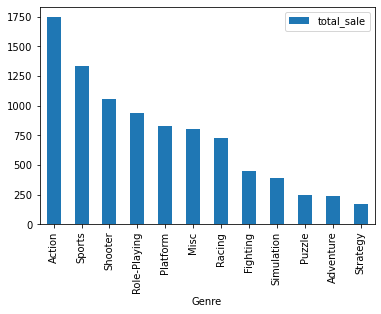

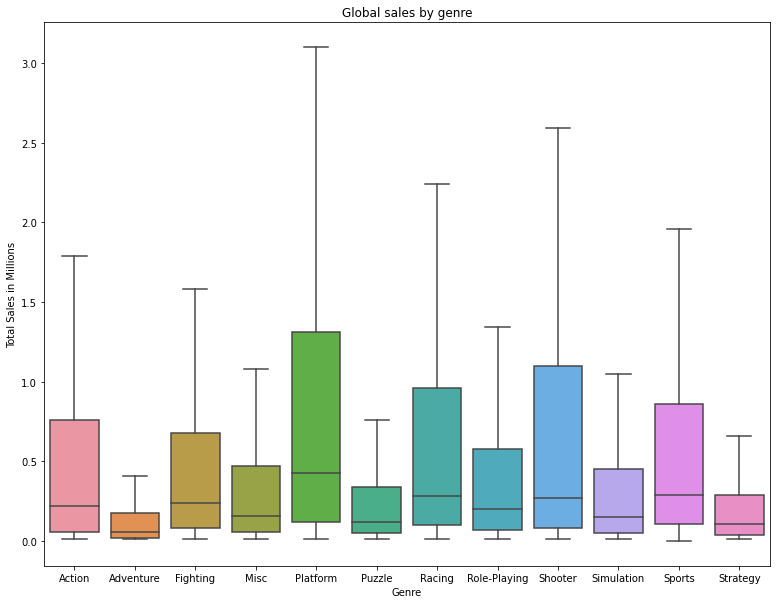

In [22]:
games_df.groupby('Genre')['total_sale'].sum().reset_index()\
.sort_values('total_sale', ascending=False).plot.bar(x='Genre')

genre_pivot=games_df.pivot_table(index='Name', columns='Genre', values='total_sale', aggfunc='sum')
plt.figure(figsize=(13,10))
sns.boxplot(data=genre_pivot, showfliers=False).set(title='Global sales by genre', ylabel='Total Sales in Millions')

plt.show()

We can see that Action games have higher total sales the all other genres by a big marign. We can also see that the highest total sales genres are games where there's no much thinking involve. In contrast with the lowest grossing genres like Strategy, Adventure and Puzzle where deeper thinking is needed. We can also see that the mean total sale for the top 5 genres have no significant difference and are higher then the other lower grossing genres

## Step 4. Create a user profile for each region

Determining the top five platforms for each region. Describing variations in their market shares from region to region.

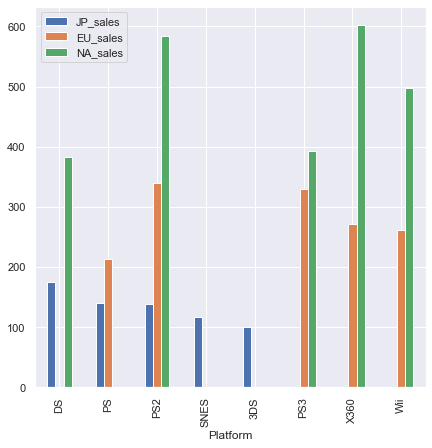

In [23]:
#JP region
sns.set(rc={'figure.figsize':(5,5)})
jp_top_plat=games_df.groupby('Platform')['JP_sales'].sum().reset_index()\
.sort_values('JP_sales', ascending=False).head(5)
#EU region
eu_top_plat=games_df.groupby('Platform')['EU_sales'].sum().reset_index()\
.sort_values('EU_sales', ascending=False).head(5)
#NA region
na_top_plat=games_df.groupby('Platform')['NA_sales'].sum().reset_index()\
.sort_values('NA_sales', ascending=False).head(5)

merged_top_plat=pd.merge(jp_top_plat, eu_top_plat, on='Platform', how='outer')
merged_top_plat=pd.merge(merged_top_plat, na_top_plat, on='Platform', how='outer')
merged_top_plat.plot.bar(x='Platform', figsize=(7,7))
plt.show()

We can see that the EU market share for top 5 platform is double of that of Japan, the North America market share is double that of Europe. We can also see that PS2 and x360 is most popular in NA.

Determining the top five geners for each region. Describing variations in their market shares from region to region.

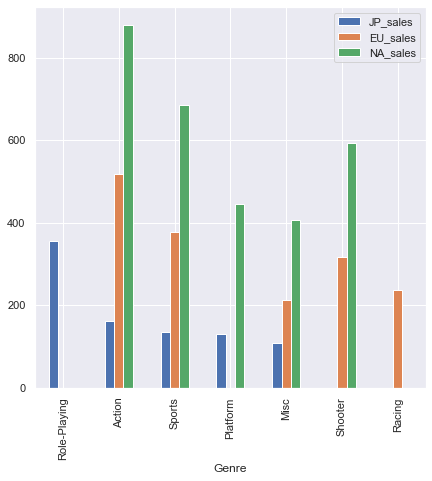

In [24]:
#JP region
jp_top_gen=games_df.groupby('Genre')['JP_sales'].sum().reset_index()\
.sort_values('JP_sales', ascending=False).head(5)
#EU region
eu_top_gen=games_df.groupby('Genre')['EU_sales'].sum().reset_index()\
.sort_values('EU_sales', ascending=False).head(5)
#NA region
na_top_gen=games_df.groupby('Genre')['NA_sales'].sum().reset_index()\
.sort_values('NA_sales', ascending=False).head(5)

merged_top_gen=pd.merge(jp_top_gen, eu_top_gen, on='Genre', how='outer')
merged_top_gen=pd.merge(merged_top_gen, na_top_gen, on='Genre', how='outer')
merged_top_gen.plot.bar(x='Genre', figsize=(7,7))
plt.show()

we can see that 3 genres are popular on the 3 regions: Shooter, Sports and Action. NA is leading the sales on all 3 genres, after EU and lastly JP. Role-Playing genre is only popular in JP and is top 1 genre there. Racing genre is only poplar in EU, where Platform genre is unpoplar in contrast to JP and NA.

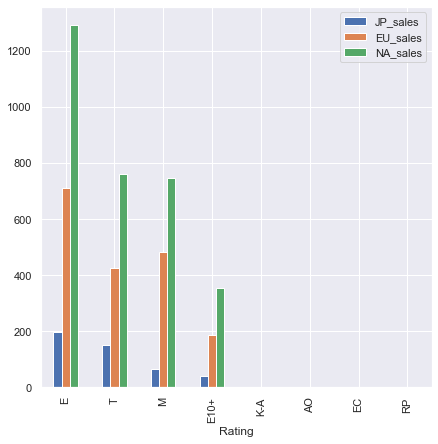

In [25]:
#Do ESRB ratings affect sales in individual regions?
#JP region
jp_esrb=games_df.groupby('Rating')['JP_sales'].sum().reset_index()\
.sort_values('JP_sales', ascending=False)
#EU region
eu_esrb=games_df.groupby('Rating')['EU_sales'].sum().reset_index()\
.sort_values('EU_sales', ascending=False)
#NA region
na_esrb=games_df.groupby('Rating')['NA_sales'].sum().reset_index()\
.sort_values('NA_sales', ascending=False)

merged_esrb=pd.merge(jp_esrb, eu_esrb, on='Rating', how='outer')
merged_esrb=pd.merge(merged_esrb, na_esrb, on='Rating', how='outer')
merged_esrb.plot.bar(x='Rating', figsize=(7,7))
plt.show()


We can see that E rating is most popular on all regions. T and M ratings are next popular ratings, and E10+ is the least popular rating in terms of sales.

## Step 5. Test the following hypotheses:

Average user ratings of the Xbox One and PC platforms are the same. 
The null hypothesis 
H0: The average user ratings of the Xbox One and PC platforms are the same.

The alternative hypothesis 
H1: The average user ratings of the Xbox One and PC platforms are different.

In [26]:
#XOne user score
x1_mean_rating=games_df[games_df['Platform']=='XOne']['User_Score'].dropna()
#PC user score
pc_mean_rating=games_df[games_df['Platform']=='PC']['User_Score'].dropna()
#st Levene test
st.levene(x1_mean_rating, pc_mean_rating, center='mean')
#The sample group don't have equal veriance, so we will use equal_var=False

LeveneResult(statistic=3.1662496092712744, pvalue=0.07549452472408175)

The levene test is used to determine whether two or more groups have equal variances. In this case the p value is larger then 0.05 therefor I will use equal_var=False in the ttest.

In [27]:
alpha=0.05 #The critical statistical significance level which is the industry standard
result1=st.ttest_ind(x1_mean_rating, pc_mean_rating, equal_var=False)
print('p-value:', result1.pvalue)

if result1.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 4.935072360183565e-06
We reject the null hypothesis


The mean user ratings of the Xbox One and PC platforms are not the same.

Testing if the average user ratings for the Action and Sports genres are different. 
The null hypothesis 
H0: The average user ratings for the Action and Sports genres are the same.

The alternative hypothesis 
H1: the average user ratings for the Action and Sports genres are different.

In [28]:
#XOne user score
x1_mean_sport=games_df[games_df['Genre']=='Sports']['User_Score'].dropna()
#PC user score
pc_mean_action=games_df[games_df['Genre']=='Action']['User_Score'].dropna()
#st Levene test
st.levene(x1_mean_sport, pc_mean_action, center='mean')
#The sample group don't have equal veriance, so we will use equal_var=False

LeveneResult(statistic=20.782708914182898, pvalue=5.355232768513885e-06)

In [29]:
alpha=0.05 #The critical statistical significance level which is the industry standard
result2=st.ttest_ind(x1_mean_rating, pc_mean_rating, equal_var=False)
print('p-value:', result2.pvalue)

if result2.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 4.935072360183565e-06
We reject the null hypothesis


The average user ratings for the Action and Sports genres are different.

In conclusion we can say that the users scores are statisticly different between XOne and PC, and Action and Sports genre.

## General conclusion

I have examined the data, and decided to leave the nan values as there are many of them under user and proffesional scores columns, but I did not replace them with any value as it will be hard to predict the user score for them, and it might effect the data distribution. This will not effect our work. 

I have also found that popular platforms have a life between 10-11 years which after that their sales fade away. In addition I found that PS4 and XOne are currently showing strong sale performance, and both were released in 2013.

Additionaly I found that the mean of global sales of all games, broken down by platform do not differ greatly except one oulier platform, GB. In addition I found no strong correlation between critic scores and total sales, however there is a weak correlation for games with more then 75 critic score.

I also found that the NA market is dominent follwing EU and JP. Action and sport genres and most popular, and most games released had E ratings.

My conclusion is that in order to plan an advertising campaigns all over the world, first the campign need to focus on games the are on XOne and PS4, as their sales are increaing. The marketing campign need to focus on games with Action, Sports and Misc on all regions, shooter genre on EU and NA, and role-playing games in the JP market. I would also suggest to market games with critic core of more then 75


